In [1]:
import copy
import os
import pickle
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import sklearn

from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl

# Load Data

## Raw data

In [2]:
folder_data = 'data/'
fn_data = 'tmb_mskcc_2018_clinical_data.tsv'
fp_data = os.path.join(folder_data, fn_data)

KEY_SURVIVAL_MONTH = 'Overall Survival (Months)'
KEY_CANCER_TYPE = 'Cancer Type'
KEY_DRUG_TYPE = 'Drug Type'
KEY_PATIENT_ID = 'Patient ID'
KEY_OVERALL_STATUS = 'Overall Survival Status'
KEY_EVENT = 'Event'

raw_data_df = pd.read_csv(fp_data, sep='\t', index_col=1)
print('Number of records:', raw_data_df.shape[0])

event = np.zeros(len(raw_data_df), dtype=np.int32)
event[raw_data_df[KEY_OVERALL_STATUS] == '1:DECEASED'] = 1
raw_data_df[KEY_EVENT] = event
raw_data_df.head(4)

('Number of records:', 1661)


,Study ID,Sample ID,Age at Which Sequencing was Reported (Days),Age Group at Diagnosis in Years,Cancer Type,Cancer Type Detailed,Drug Type,Gene Panel,Institute Source,Metastatic Site,...,Primary Tumor Site,Sample Class,Number of Samples Per Patient,Sample coverage,Sample Type,Sex,Somatic Status,TMB Score,Tumor Purity,Event
Patient ID,,,,,,,,,,,,,,,,,,,,,
P-0000057,tmb_mskcc_2018,P-0000057-T01-IM3,41.0,31-50,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,Breast,Tumor,1,835,Primary,Female,Matched,5.580000,25,1
P-0000062,tmb_mskcc_2018,P-0000062-T01-IM3,80.0,>71,Esophagogastric Cancer,Adenocarcinoma of the Gastroesophageal Junction,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,Esophagus,Tumor,1,1176,Primary,Male,Matched,6.691462,30,1
P-0000063,tmb_mskcc_2018,P-0000063-T01-IM3,62.0,61-70,Bladder Cancer,Bladder Urothelial Carcinoma,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,Bladder,Tumor,1,900,Primary,Male,Matched,16.728656,70,0
P-0000071,tmb_mskcc_2018,P-0000071-T01-IM3,66.0,61-70,Bladder Cancer,Bladder Urothelial Carcinoma,PD-1/PDL-1,IMPACT341,MSKCC,NaN,...,Bladder,Tumor,1,795,Primary,Male,Matched,11.152437,30,0


In [3]:
raw_data_df = raw_data_df[raw_data_df[KEY_DRUG_TYPE]=='PD-1/PDL-1']
raw_data_df = raw_data_df[[KEY_CANCER_TYPE, KEY_SURVIVAL_MONTH, KEY_EVENT]]
raw_data_df.head(4)

,Cancer Type,Overall Survival (Months),Event
Patient ID,,,
P-0000057,Breast Cancer,0,1
P-0000062,Esophagogastric Cancer,1,1
P-0000063,Bladder Cancer,42,0
P-0000071,Bladder Cancer,43,0


## Pre-computed time series

In [4]:
ts_pd1_df = pd.read_csv('data/km_pd1_df.csv')
ts_pd1_df.head(4)

,Cancer Type,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,Bladder Cancer,0.989583,0.958168,0.909721,0.849800,0.803864,0.780046,0.737052,0.697211,0.682982,...,0.546154,0.504935,0.493459,0.481123,0.455800,0.414364,0.414364,0.414364,0.396348,0.396348
1,Colorectal Cancer,1.000000,0.979798,0.919192,0.876439,0.832062,0.787086,0.775160,0.713640,0.701120,...,0.539263,0.519290,0.519290,0.495686,0.495686,0.495686,0.495686,0.460280,0.460280,0.460280
2,Glioma,0.991228,0.982378,0.928794,0.893071,0.847966,0.775799,0.730164,0.702782,0.656547,...,0.422849,0.368638,0.297289,0.272515,0.245263,0.231637,0.204386,0.177135,0.144928,0.144928
3,Head and Neck Cancer,1.000000,0.977099,0.884775,0.828471,0.767426,0.740963,0.713854,0.666890,0.607169,...,0.406892,0.386547,0.386547,0.386547,0.358937,0.358937,0.326306,0.290050,0.217537,0.217537


# Function definitions

In [5]:
# Row space test from Ken's notebook

# hard singular value thresholding (hsvt)
def hsvt(X, rank=2, return_all=False):
    """
    Input:
        X: donor data (#samples x #donor units)
        rank: #singular values of X to retain
    Output:
        low rank approximateion of X
    """
    if rank is None:
        return X
    u, s, v = np.linalg.svd(X, full_matrices=False)
    s[rank:].fill(0)
    if return_all:
        return np.dot(u * s, v), u[:,:rank], s[:rank], v[:rank,:]
    return np.dot(u * s, v)

def approximate_rank2(X, t = 0):
    """
    Input:
        X: donor data (#samples x #donor units)
        t: percentage of spectral energy to retain 
    Output:
        rank: approximate rank of X
    """
    _, s, _ = np.linalg.svd(X, full_matrices=False)
    b = X.shape[1]/X.shape[0]
    omega = 0.56*b**3-0.95*b**2+1.43+1.82*b
    thre = omega*np.median(s)
    rank = len(s[s>thre])
    return rank

def si_row_space_test(X_train, X_test):
    """
    Implements the row-space test described in one of the S-I papers.
    """

    k = approximate_rank2(X_train)
    X_train_hat, u1, s1, v1 = hsvt(X_train, rank=k, return_all=True)
    v1 = v1.T

    X_test_hat, u2, s2, v2 = hsvt(X_test, rank=k, return_all=True)   
    v2 = v2.T

    tau = np.linalg.norm(v2 - v1.dot(v1.T.dot(v2)), ord='fro')**2

    return tau, k

def sc_row_space_test(M_pre, M_post, rank):
    """
    Implements the row-space test described for S-C
    """
    def _get_v_hat(M, rank):
        u, s, v = np.linalg.svd(M, full_matrices=False)
        v = v.T
        return v[:,:rank]
    
    v_hat_pre = _get_v_hat(M_pre, rank)
    v_hat_post = _get_v_hat(M_post, rank)
    
    return np.linalg.norm(
        v_hat_post - v_hat_pre.dot(v_hat_pre.T.dot(v_hat_post)), ord='fro')**2
    

In [6]:
def predict_and_plot(ts_pd1_df, target_type, moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2):
    other_types = list(ts_pd1_df['Cancer Type'])
    other_types.remove(target_type)
    months = [str(i) for i in range(moStart, moTestEnd + 1)]
    p = 1.0

    trainingMonths = [str(i) for i in range(moStart, moTrainEnd + 1)]
    testMonths = [str(i) for i in range(moTrainEnd + 1, moTestEnd + 1)]

    trainDataMasterDict = {}
    trainDataDict = {}
    testDataDict = {}
    for key in other_types:
      series = ts_pd1_df.loc[ts_pd1_df['Cancer Type'] == key]
      trainDataMasterDict.update({key: series[trainingMonths].values[0]})
      # randomly hide training data
      (trainData, pObservation) = tsUtils.randomlyHideValues(copy.deepcopy(trainDataMasterDict[key]), p)
      trainDataDict.update({key: trainData})
      testDataDict.update({key: series[testMonths].values[0]})
        
    series = ts_pd1_df[ts_pd1_df['Cancer Type'] == target_type]
    trainDataMasterDict.update({target_type: series[trainingMonths].values[0]})
    trainDataDict.update({target_type: series[trainingMonths].values[0]})
    testDataDict.update({target_type: series[testMonths].values[0]})

    trainMasterDF = pd.DataFrame(data=trainDataMasterDict)
    trainDF = pd.DataFrame(data=trainDataDict)
    testDF = pd.DataFrame(data=testDataDict)
    tau = sc_row_space_test(trainDF, testDF, singvals)
    
    rscModel = RobustSyntheticControl(
        target_type, singvals, len(trainDF), probObservation=1.0, modelType='svd',
        svdMethod='numpy', otherSeriesKeysArray=other_types)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    
    predictions = []
    predictions = np.dot(testDF[other_types], rscModel.model.weights)
    actual = ts_pd1_df.loc[ts_pd1_df['Cancer Type'] == target_type][months]
    actual = actual.iloc[0]
    model_fit = np.dot(trainDF[other_types][:], rscModel.model.weights)   
    

    r2_score = sklearn.metrics.r2_score(actual[testMonths], predictions)
    fig, ax = plt.subplots(1,1)
    tick_spacing = 5
    # this is a bug in matplotlib
    label_markings = np.insert(months[::tick_spacing], 0, 'dummy')

    ax.set_xticks(np.arange(len(label_markings)))
    ax.set_xticklabels(label_markings, rotation=45)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    plt.step(months, actual, label='actual', where='post')
    plt.xlabel('Months after treatment')
    plt.ylabel('Survival rate')
    plt.step(trainingMonths, model_fit, label='fitted model', where='post')
    plt.step(testMonths, predictions, label='counterfactual', where='post')
    plt.title('\n'.join([
        target_type+' (singular values used: '+str(singvals)+')',
        'R2 score: %.4f'%r2_score + ', tau: %.6f'%tau
    ]))

    xposition = pd.to_datetime(moTrainEnd,  errors='coerce')
    plt.axvline(x=str(moTrainEnd), color='k', linestyle='--', linewidth=4)
    plt.grid()
    plt.legend()
    fn = target_type.replace(',', '').replace(' ', '_')
    fn = fn + '-%d-%d'%(moTrainEnd, moTestEnd) +'-svd%d'%singvals + '.png'
    plt.savefig(fn, dpi=200)

# Run experiments

## Non-Small Cell Lung Cancer

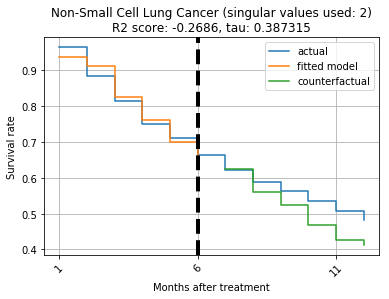

In [7]:
target_type = 'Non-Small Cell Lung Cancer'
predict_and_plot(ts_pd1_df, target_type, moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2)

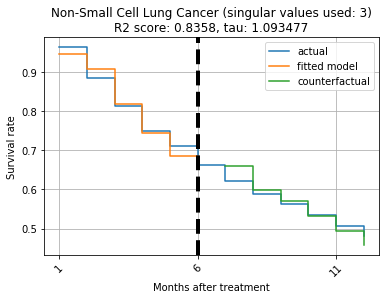

In [8]:
predict_and_plot(ts_pd1_df, 'Non-Small Cell Lung Cancer',
                 moStart=1, moTrainEnd=6, moTestEnd=12, singvals=3)

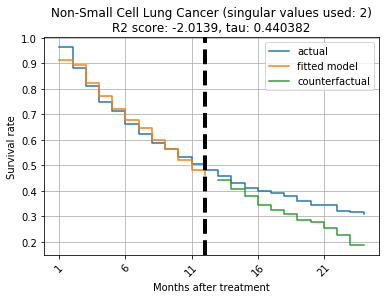

In [9]:
predict_and_plot(ts_pd1_df, 'Non-Small Cell Lung Cancer',
                 moStart=1, moTrainEnd=12, moTestEnd=24, singvals=2)

## Melanoma

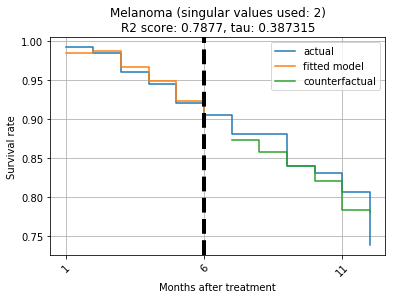

In [10]:
predict_and_plot(ts_pd1_df, 'Melanoma',
                 moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2)

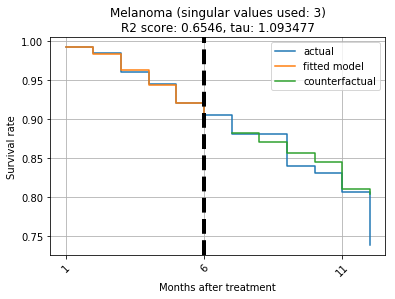

In [11]:
predict_and_plot(ts_pd1_df, 'Melanoma',
                 moStart=1, moTrainEnd=6, moTestEnd=12, singvals=3)

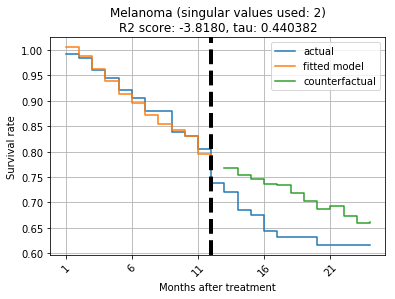

In [12]:
predict_and_plot(ts_pd1_df, 'Melanoma',
                 moStart=1, moTrainEnd=12, moTestEnd=24, singvals=2)

## Colorectal Cancer

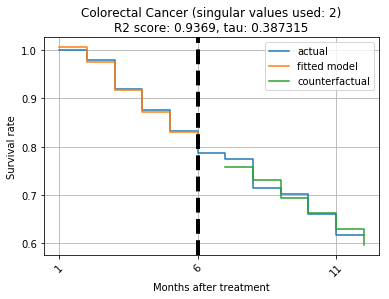

In [13]:
predict_and_plot(ts_pd1_df, 'Colorectal Cancer',
                 moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2)

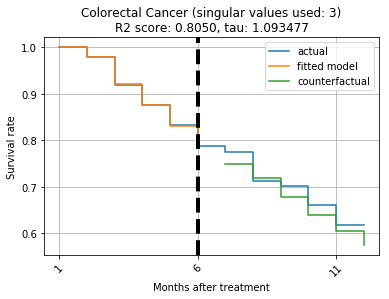

In [14]:
predict_and_plot(ts_pd1_df, 'Colorectal Cancer',
                 moStart=1, moTrainEnd=6, moTestEnd=12, singvals=3)

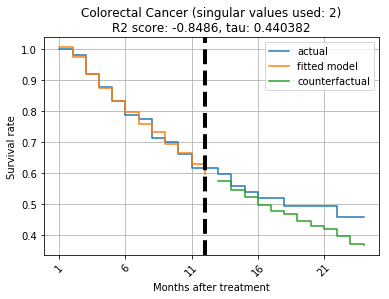

In [15]:
predict_and_plot(ts_pd1_df, 'Colorectal Cancer',
                 moStart=1, moTrainEnd=12, moTestEnd=24, singvals=2)

## Bladder Cancer

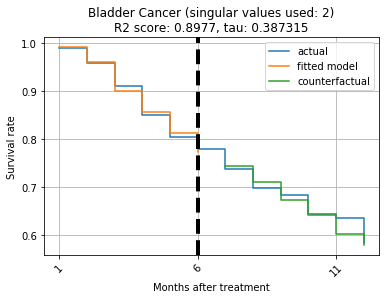

In [16]:
predict_and_plot(ts_pd1_df, 'Bladder Cancer',
                 moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2)

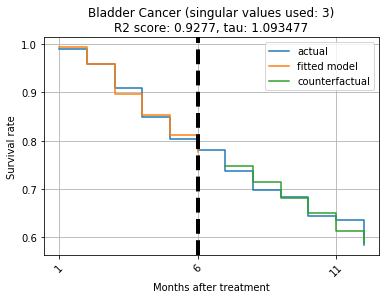

In [17]:
predict_and_plot(ts_pd1_df, 'Bladder Cancer',
                 moStart=1, moTrainEnd=6, moTestEnd=12, singvals=3)

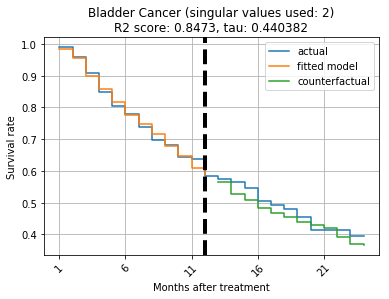

In [18]:
predict_and_plot(ts_pd1_df, 'Bladder Cancer',
                 moStart=1, moTrainEnd=12, moTestEnd=24, singvals=2)

## Glioma

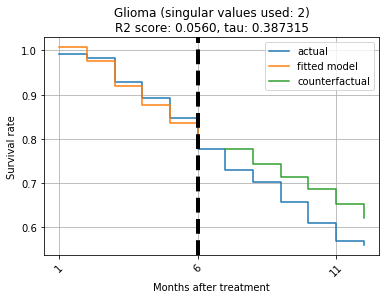

In [19]:
predict_and_plot(ts_pd1_df, 'Glioma',
                 moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2)

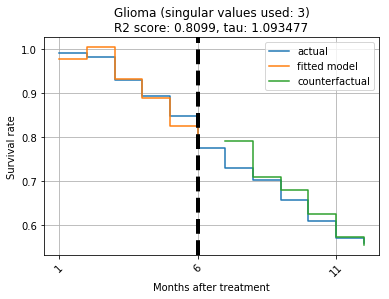

In [20]:
predict_and_plot(ts_pd1_df, 'Glioma',
                 moStart=1, moTrainEnd=6, moTestEnd=12, singvals=3)

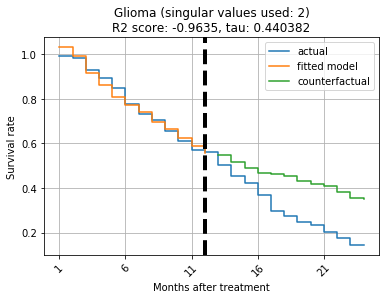

In [21]:
predict_and_plot(ts_pd1_df, 'Glioma',
                 moStart=1, moTrainEnd=12, moTestEnd=24, singvals=2)